<a href="https://colab.research.google.com/github/0v3r-9000/trc204.github.io/blob/main/Fertility_Status%20/%20Fertility_Status.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values before preprocessing:
 Season                                   0
Age                                      0
Childish diseases                        0
Accident or serious trauma               0
Surgical intervention                    0
High fevers in the last year             0
Frequency of alcohol consumption         0
Smoking habit                            0
Number of hours spent sitting per day    0
Diagnosis                                0
dtype: int64
Accuracy: 0.94
Precision: 0.90
Recall: 1.00
F1-score: 0.95
ROC AUC: 0.06
Confusion Matrix:
 [[18  0]
 [ 2 16]]


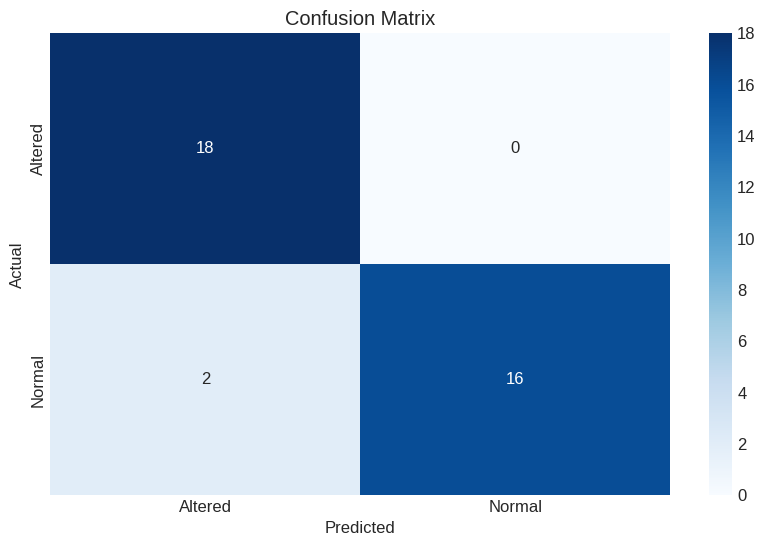

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn and imbalanced-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

# === Load dataset ===
df = pd.read_csv('fertility.csv')
print("Missing values before preprocessing:\n", df.isnull().sum())

# === Binary columns map ===
binary_map = {'yes': 1, 'no': 0}
# Apply binary mapping only to columns that are strictly binary 'yes'/'no'
df['Accident or serious trauma'] = df['Accident or serious trauma'].map(binary_map)
df['Surgical intervention'] = df['Surgical intervention'].map(binary_map)
df['Childish diseases'] = df['Childish diseases'].map(binary_map) # Assuming Childish diseases is also binary

# === Ordinal encoding ===
ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) # Handle unknown values
df[['Season', 'Frequency of alcohol consumption', 'Smoking habit', 'High fevers in the last year']] = ord.fit_transform(
    df[['Season', 'Frequency of alcohol consumption', 'Smoking habit', 'High fevers in the last year']]
)

# === One-hot encoding for 'Childish diseases' ===
# OHE is not needed if Childish diseases is binary as per binary_map
# If Childish diseases has more than two categories, uncomment and adjust the OHE code:
# ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
# encoded_childish = pd.DataFrame(
#     ohe.fit_transform(df[['Childish diseases']]),
#     columns=ohe.get_feature_names_out(['Childish diseases']),
#     index=df.index
# )
# df = pd.concat([df.drop(columns=['Childish diseases']), encoded_childish], axis=1)


# === Feature engineering ===
df['habits'] = (df['Frequency of alcohol consumption'] * 2) + df['Smoking habit']

def categorize_sitting_hours(hours):
    if 0 <= hours <= 4:
        return 1
    elif 5 <= hours <= 8:
        return 2
    else:
        return 3

df['Sitting_Hours_Category'] = df['Number of hours spent sitting per day'].apply(categorize_sitting_hours)

# === Feature scaling ===
features_to_scale = ['Age', 'Season', 'Frequency of alcohol consumption',
                     'Number of hours spent sitting per day', 'habits', 'Sitting_Hours_Category', 'High fevers in the last year']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# === Data split ===
target = 'Diagnosis'
X = df.drop(columns=[target])
y = df[target]

# === SMOTE oversampling ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y) # Use full data for SMOTE before splitting

# === Data split after SMOTE ===
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)


# === Model training ===
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train) # Train on the post-SMOTE training data

# === Prediction and evaluation ===
y_pred = model.predict(X_test)
# Find the index of the 'Altered' class in model.classes_
altered_class_index = model.classes_.tolist().index('Altered')
y_pred_proba = model.predict_proba(X_test)[:, altered_class_index] # Probability of the positive class


# === Metrics ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Altered', zero_division=1)
recall = recall_score(y_test, y_pred, pos_label='Altered')
f1 = f1_score(y_test, y_pred, pos_label='Altered')
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Altered', 'Normal'])

# === Output ===
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("Confusion Matrix:\n", conf_matrix)

# === Confusion matrix heatmap ===
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Altered', 'Normal'], yticklabels=['Altered', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()